In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

from tqdm import tqdm

/home/s.gostilovich/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:0' #torch.device(torch.cuda.get_device_name(1))

# Low Rank Autoencoder

### Blocked autoencoder

In [3]:
class EncoderDecoder(nn.Module):
    def __init__(self, in_features, out_features, nonlinearity):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features   
        self.nonlinearity = nonlinearity
        
        self.encoder_decoder = nn.Sequential(nn.Linear(in_features, out_features),
                                     nonlinearity,
                                    #  nn.Linear(out_features, out_features)
                                     )
    
    def forward(self, x):
        return self.encoder_decoder(x)

In [4]:
# DIFFERENT SAMPLING FUNCTIONS

def vector_sampling(normalized_factors, grid):
    encoded = normalized_factors @ grid
    return encoded

def softmax_sampling(normalized_factors, grid, temperature=0.01):
    B, out_features, n_bins = normalized_factors.shape
    cumsum_factors = torch.cumsum(normalized_factors, dim=-1)          # cumsum over bins
    y = torch.rand(B, out_features,1).to(device)                       # uniform random 
    abs_factors = torch.abs(cumsum_factors - y)                        # finding closest x via argmax
    final_factors = torch.softmax(-abs_factors/temperature, dim=-1)
    encoded = final_factors @ grid
    return encoded

def gumbell_sampling(normalized_factors, grid, temperature=0.01):
    eps = 1e-20
    logit_factors = torch.log(normalized_factors+eps) 
    y_unit = torch.rand(logit_factors.shape).to(device)
    y_logs = -torch.log(-torch.log(y_unit + eps) + eps)
    final_factors = torch.softmax((logit_factors + y_logs)/temperature, dim=-1)
    encoded = final_factors @ grid
    return encoded

# SHIFTED MASKING FUNCTION - didn't prove to be of much help
def masking(normalized_factors, mask_size):
    B, out_features, n_bins = normalized_factors.shape
    assert n_bins % mask_size == 0 , f'n_bins={n_bins} must be divisible by mask_size={mask_size}'
    eps = 1e-9
    mask = torch.ones(B, out_features, n_bins).to(device)
    mask[::,::,0:mask_size] = 0
    mask = torch.roll(mask, torch.randint(low=0,high=n_bins-mask_size+1, size=(1,)).item(), dims=-1)
    dropped_factors = mask*normalized_factors + eps
    return dropped_factors

In [5]:
# Low Rank Pants class
class LowRankPants(nn.Module):
    def __init__(self, inter_features, out_features, n_bins, dropout, sampling, temperature):
        super().__init__()
        self.inter_features = inter_features
        self.out_features = out_features
        self.n_bins = n_bins
        self.dropout = dropout
        # sampling
        self.sampling = sampling
        self.temperature = temperature
        
        assert sampling in {'vector', 'softmax', 'gumbell'}, 'No such sampling method, select vector, softmax, gumbell'
        
        # coeff for logarithms
        self.eps = 1e-4/(n_bins*out_features)
        
        # coord grid
        grid = (torch.arange(1,n_bins+1)).to(device)
        self.grid = grid /n_bins
        
        # mapping to final probabilities (штаны)
        self.layers = nn.ModuleList([nn.Sequential(
                                                   nn.Linear(inter_features, n_bins),
                                                   nn.Sigmoid()
                                                  )
                                                   for i in range(out_features)]
                                   )

        # dropout for randromized sampling
        self.dropout = nn.Dropout(dropout)
        
    # even faster forward - inner products with the range vec
    def forward(self,x):
        B = x.shape[0]

        # getting additional linear layer
        factors_list = []
        for layer in self.layers:
            factors_list.append(layer(x)) # (B, n_bins)
        # stack  them up
        factors = torch.stack(factors_list, dim=-1)
        factors_reshaped = factors.view(B, self.out_features, self.n_bins) # size = (B, out_features, n_bins)
        factors_probability = factors_reshaped/(torch.sum(factors_reshaped, dim=-1, keepdim=True))
        
        # randomized selection + added eps
        dropped_factors = self.dropout(factors_probability) + self.eps
        
        # normalization
        normalized_drop_factors = dropped_factors/(torch.sum(dropped_factors, dim=-1, keepdim=True))
        
        # choosing the sampling
        if self.sampling == 'vector':
            encoded =  vector_sampling(normalized_drop_factors, self.grid)
        elif self.sampling == 'softmax':
            encoded = softmax_sampling(normalized_drop_factors, self.grid, self.temperature)
        elif self.sampling == 'gumbell':
            encoded = gumbell_sampling(normalized_drop_factors, self.grid, self.temperature)
        
        return encoded, factors_probability

In [6]:
# Low Rank Pants class
class PantsVAE(nn.Module):
    def __init__(self, inter_features, out_features, nonlinearity):
        super().__init__()
        self.inter_features = inter_features
        self.out_features = out_features
        self.mu = EncoderDecoder(inter_features, out_features, nonlinearity)
        self.sigma = EncoderDecoder(inter_features, out_features, nonlinearity)
        
    def forward(self,x):
        mu = self.mu(x)
        sigma = torch.exp(self.sigma(x))
        rand = torch.randn(mu.shape).to(device)
        encoded = rand*sigma + mu
        
        KL = sigma**2 + mu**2 - torch.log(sigma) - 1/2
        
        return encoded, KL

In [7]:
# Low Rank Pants class
class PantsAE(nn.Module):
    def __init__(self, inter_features, out_features, nonlinearity):
        super().__init__()
        self.inter_features = inter_features
        self.out_features = out_features
        self.out = EncoderDecoder(inter_features, out_features, nonlinearity)
        
    def forward(self,x):
        encoded = self.out(x)
        
        return encoded, None

In [8]:
class InternalAutoencoder(nn.Module):
    def __init__(self, in_features, inter_features, out_features, nonlinearity):
        super().__init__() 
        # network feature sizes
        self.in_features = in_features
        self.inter_features = inter_features
        self.out_features = out_features

        # network params
        self.nonlinearity = nonlinearity


        
        # encoder
        self.encoder = EncoderDecoder(in_features, inter_features, nonlinearity)
        
        # low rank probabilites
        self.low_rank_pants = PantsAE(inter_features, out_features, nonlinearity)
        
        # intermediate_decoder
        self.intermediate_decoder = EncoderDecoder(out_features, inter_features, nonlinearity)
        
        # final decoder
        self.decoder = EncoderDecoder(inter_features, in_features, nonlinearity)
        
    def forward(self, x):
        encoded_inter_dim = self.encoder(x) # from flatten dim to inter dim
        
        encoded, _ = self.low_rank_pants(encoded_inter_dim)
        
        decoded_inter_dim = self.intermediate_decoder(encoded)
        decoded = self.decoder(decoded_inter_dim)# from inter dim to flatten dim
        return decoded

In [9]:
class InternalVAutoencoder(nn.Module):
    def __init__(self, in_features, inter_features, out_features, nonlinearity):
        super().__init__() 
        # network feature sizes
        self.in_features = in_features
        self.inter_features = inter_features
        self.out_features = out_features

        # network params
        self.nonlinearity = nonlinearity


        
        # encoder
        self.encoder = EncoderDecoder(in_features, inter_features, nonlinearity)
        
        # low rank probabilites
        self.low_rank_pants = PantsVAE(inter_features, out_features, nonlinearity)
        
        # intermediate_decoder
        self.intermediate_decoder = EncoderDecoder(out_features, inter_features, nonlinearity)
        
        # final decoder
        self.decoder = EncoderDecoder(inter_features, in_features, nonlinearity)
        
    def forward(self, x):
        encoded_inter_dim = self.encoder(x) # from flatten dim to inter dim
        
        encoded, _ = self.low_rank_pants(encoded_inter_dim)
        
        decoded_inter_dim = self.intermediate_decoder(encoded)
        decoded = self.decoder(decoded_inter_dim)# from inter dim to flatten dim
        return decoded

In [10]:
class LowRankAutoencoder(nn.Module):
    def __init__(self, in_features, inter_features, out_features, n_bins,
                 dropout, nonlinearity,
                 sampling, temperature):
        super().__init__() 
        # network feature sizes
        self.in_features = in_features
        self.inter_features = inter_features
        self.out_features = out_features
        self.n_bins = n_bins
        # network params
        self.nonlinearity = nonlinearity
        self.dropout = dropout
        # sampling params
        self.sampling = sampling
        self.temperature = temperature
        
        # encoder
        self.encoder = EncoderDecoder(in_features, inter_features, nn.ELU())
        
        # low rank probabilites
        self.low_rank_pants = LowRankPants(inter_features, out_features, n_bins, dropout, sampling, temperature)
        
        # intermediate_decoder
        self.intermediate_decoder = EncoderDecoder(out_features, inter_features, nn.ELU())
        
        # final decoder
        self.decoder = EncoderDecoder(inter_features, in_features, nn.ELU())
        
    def forward(self, x):
        encoded_inter_dim = self.encoder(x)
        encoded_out_dim, factors_probability = self.low_rank_pants(encoded_inter_dim)
        decoded_inter_dim = self.intermediate_decoder(encoded_out_dim)
        decoded = self.decoder(decoded_inter_dim)
        return decoded

In [11]:
LRA = LowRankAutoencoder(in_features=10, inter_features=20, out_features=2, n_bins=20,
                         dropout=0.2, nonlinearity=nn.ELU(),
                         sampling='vector', temperature=0.1).to(device)

ttt = torch.rand(16, 10).to(device)
LRA(ttt).shape

torch.Size([16, 10])

In [12]:
IA = InternalAutoencoder(in_features=10, inter_features=20, out_features=2, nonlinearity=nn.ELU()).to(device)

ttt = torch.rand(16, 10).to(device)
LRA(ttt).shape

torch.Size([16, 10])

In [13]:
IA = InternalVAutoencoder(in_features=10, inter_features=20, out_features=2, nonlinearity=nn.ELU()).to(device)

ttt = torch.rand(16, 10).to(device)
LRA(ttt).shape

torch.Size([16, 10])

# Convolutional autoencoder
## Up and Down Blocks

In [14]:
class DownsampleBlock(nn.Module):
    def __init__(self, in_features, out_features, nonlinearity=nn.ELU()):
        super().__init__()
        self.conv = nn.Conv2d(in_features, out_features,
                               kernel_size=4, stride=2, padding=1, dilation=1)
        self.nonlinearity = nonlinearity
    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.nonlinearity(x1)
        return x2

In [15]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_features, out_features, scale_factor=2, nonlinearity=nn.ELU()):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_features, out_features,
                                            kernel_size=4, output_padding=0, padding=1, stride=2)
        self.nonlinearity = nonlinearity
    def forward(self, x):
        x1 = self.upsample(x)
        x2 = self.nonlinearity(x1)
        return x2

In [16]:
db = DownsampleBlock(in_features=8, out_features=8)
ttt = torch.rand(16,8,32,32)
db(db(db(ttt))).shape

torch.Size([16, 8, 4, 4])

In [17]:
ub = UpsampleBlock(in_features=8, out_features=8,)

ub(ub(ub(db(db(db(ttt)))))).shape

torch.Size([16, 8, 32, 32])

In [18]:
class ConvVAE(nn.Module):
    def __init__(self, in_features, inter_features, out_features, nonlinearity, img_size=(24,24)):
        super().__init__()
        
        self.in_features = in_features   # input features after convolutions and flattening
        self.out_features = out_features # encoded dimension

        # for flattening
        self.img_size = img_size
        self.flat_size = img_size[0]//8
        # network params
        self.nonlinearity = nonlinearity


        
        self.down = nn.Sequential(nn.Dropout(0.2),
                                  DownsampleBlock(in_features=1, out_features=32, nonlinearity=nonlinearity),
                                  DownsampleBlock(in_features=32, out_features=64, nonlinearity=nonlinearity),
                                  DownsampleBlock(in_features=64, out_features=128, nonlinearity=nonlinearity),
                                  )
        
        self.low_rank = InternalVAutoencoder(in_features, inter_features, out_features,nonlinearity)
        
        self.up = nn.Sequential(
                                UpsampleBlock(in_features=128, out_features=64, nonlinearity=nonlinearity),
                                UpsampleBlock(in_features=64, out_features=32, nonlinearity=nonlinearity),
                                UpsampleBlock(in_features=32, out_features=1,  nonlinearity=nn.Sigmoid()),
                                )
        
    def forward(self, x):
        # downsample
        x_down = self.down(x)
        B, C, H, W = x_down.shape
        x_flat = x_down.view(B,C*H*W)
        
        # passing theough low rank
        decoded = self.low_rank(x_flat)

        # upsample
        x_2d = decoded.view(B, C, H, W)
        x_out = self.up(x_2d)

        return x_out

In [19]:
class ConvAE(nn.Module):
    def __init__(self, in_features, inter_features, out_features, nonlinearity, img_size=(24,24)):
        super().__init__()
        
        self.in_features = in_features   # input features after convolutions and flattening
        self.out_features = out_features # encoded dimension

        # for flattening
        self.img_size = img_size
        self.flat_size = img_size[0]//8
        # network params
        self.nonlinearity = nonlinearity


        
        self.down = nn.Sequential(nn.Dropout(0.2),
                                  DownsampleBlock(in_features=1, out_features=32, nonlinearity=nonlinearity),
                                  DownsampleBlock(in_features=32, out_features=64, nonlinearity=nonlinearity),
                                  DownsampleBlock(in_features=64, out_features=128, nonlinearity=nonlinearity),
                                  )
        
        self.low_rank = InternalAutoencoder(in_features, inter_features, out_features,nonlinearity)
        
        self.up = nn.Sequential(
                                UpsampleBlock(in_features=128, out_features=64, nonlinearity=nonlinearity),
                                UpsampleBlock(in_features=64, out_features=32, nonlinearity=nonlinearity),
                                UpsampleBlock(in_features=32, out_features=1,  nonlinearity=nn.Tanh()),
                                )
        
    def forward(self, x):
        # downsample
        x_down = self.down(x)
        B, C, H, W = x_down.shape
        x_flat = x_down.view(B,C*H*W)
        
        # passing theough low rank
        decoded = self.low_rank(x_flat)

        # upsample
        x_2d = decoded.view(B, C, H, W)
        x_out = self.up(x_2d)

        return x_out
            
            

In [20]:
class ConvLRAE(nn.Module):
    def __init__(self, in_features, inter_features, out_features, n_bins,
                 dropout, nonlinearity,
                 sampling='vector', temperature=0.1,
                img_size=(24,24)):
        super().__init__()
        
        self.in_features = in_features   # input features after convolutions and flattening
        self.out_features = out_features # encoded dimension
        self.n_bins = n_bins
        # for flattening
        self.img_size = img_size
        self.flat_size = img_size[0]//8
        # network params
        self.nonlinearity = nonlinearity
        self.dropout = dropout
        # sampling params
        self.sampling = sampling
        self.temperature = temperature

        
        self.down = nn.Sequential(nn.Dropout(0.2),
                                  DownsampleBlock(in_features=1, out_features=32, nonlinearity=nonlinearity),
                                  DownsampleBlock(in_features=32, out_features=64, nonlinearity=nonlinearity),
                                  DownsampleBlock(in_features=64, out_features=128, nonlinearity=nonlinearity),
                                  )
        
        self.low_rank = LowRankAutoencoder(in_features, inter_features, out_features, n_bins,
                                           dropout, nonlinearity,
                                           sampling, temperature)
        
        self.up = nn.Sequential(
                                UpsampleBlock(in_features=128, out_features=64, nonlinearity=nonlinearity),
                                UpsampleBlock(in_features=64, out_features=32, nonlinearity=nonlinearity),
                                UpsampleBlock(in_features=32, out_features=1,  nonlinearity=nn.Tanh()),
                                )
        
    def forward(self, x):
        # downsample
        x_down = self.down(x)
        B, C, H, W = x_down.shape
        x_flat = x_down.view(B,C*H*W)
        
        # passing theough low rank
        decoded = self.low_rank(x_flat)

        # upsample
        x_2d = decoded.view(B, C, H, W)
        x_out = self.up(x_2d)

        return x_out
            
            

In [21]:
mdl = ConvLRAE(in_features=128*4*4, inter_features=256, out_features=4, n_bins=20,
                dropout=0.1, nonlinearity=nn.ReLU()
              ).to(device)

ttt = torch.randn(10, 1, 32, 32).to(device)

mdl(ttt).shape

torch.Size([10, 1, 32, 32])

In [22]:
mdl = ConvAE(in_features=128*4*4, inter_features=256, out_features=4, nonlinearity=nn.ReLU()).to(device)

ttt = torch.randn(10, 1, 32, 32).to(device)

mdl(ttt).shape

torch.Size([10, 1, 32, 32])

In [23]:
mdl = ConvVAE(in_features=128*4*4, inter_features=256, out_features=4, nonlinearity=nn.ReLU()).to(device)

ttt = torch.randn(10, 1, 32, 32).to(device)

mdl(ttt).shape

torch.Size([10, 1, 32, 32])

### Dataset class

In [24]:
from torch.utils.data import Dataset, DataLoader

class MNIST_DS(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.X = self.X/torch.max(self.X) # normalizing to 1.
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]
        return x,y

### Torchvision dataset

In [25]:
import torchvision
from torchvision import transforms
from torch.utils.data import Subset, Dataset, DataLoader

train_ds_mnist = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 transforms.Resize(32),
                                 torchvision.transforms.ToTensor(),
                             ]))
test_ds_mnist = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 transforms.Resize(32),
                                 torchvision.transforms.ToTensor(),
                             ]))

# dataset and dataloader
TRAIN_SIZE = 60000
TEST_SIZE = 5000
BATCH_SIZE = 64
dl = DataLoader(train_ds_mnist, batch_size=BATCH_SIZE,     num_workers=10)
dl_test = DataLoader(test_ds_mnist, batch_size=BATCH_SIZE, num_workers=10)

#full dataset train
FULL_TRAIN_SIZE = 60000
dl_full = DataLoader(train_ds_mnist, batch_size=FULL_TRAIN_SIZE)
for x, y in dl_full:
    X_full_train = x
    targets = y
    break

#full dataset train
FULL_TEST_SIZE = 10000
dl_full = DataLoader(test_ds_mnist, batch_size=FULL_TEST_SIZE)
for x, y in dl_full:
    X_full_test = x
    targets_test = y
    break

print(X_full_train.shape)
print(torch.max(X_full_train))
print(targets.unique(return_counts=True))

torch.Size([60000, 1, 32, 32])
tensor(1.)
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


### Train

In [26]:
torch.manual_seed(0)

In [27]:
torch.cuda.empty_cache()

IN_FEATURES=128*4*4
INTER_FEATURES=512
OUT_FEATURES=8
NONLINEARITY = nn.ELU()
# model = ConvLRAE(in_features=128*4*4, inter_features=512, out_features=8, n_bins=10,
#                 dropout=0.2, nonlinearity=nn.ELU(),
#                 sampling='gumbell', temperature=0.1,
#                 ).to(device)

model = ConvVAE(in_features=128*4*4, inter_features=512, out_features=8, nonlinearity=nn.ELU()).to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [28]:
PATH = 'Test_path_VAE'

In [29]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 25
model.train()
optimizer.zero_grad()

loss_list_train = []
loss_train_cum = 0

loss_list_test = []
loss_test_cum = 0
loss = 0
i = 0

for epoch in tqdm(range(EPOCHS)):
    # Forward pass: Compute predicted y by passing x to the model
    
    if epoch%20 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'loss_list_train': loss_list_train,
            'loss_list_test': loss_list_test,
            
            }, PATH + f"__{epoch}.pth")
    
    
    
    for x_batch, y_batch in dl:
        model.train()

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        # model forward
        # 2d downsampling
        x_down = model.down(x_batch)
        B, C, H, W = x_down.shape
        x_flat = x_down.view(B,C*H*W)
        encoded_inter_dim = model.low_rank.encoder(x_flat)
        encoded_out_dim, factors_probability = model.low_rank.low_rank_pants(encoded_inter_dim)
        decoded_inter_dim =                    model.low_rank.intermediate_decoder(encoded_out_dim)
        decoded_1d = model.low_rank.decoder(decoded_inter_dim)
        # 2d upsampling
        decoded_2d_small = decoded_1d.view(B, C, H, W)
        decoded_2d = model.up(decoded_2d_small)

        # loss_entropy = torch.sum(torch.log(factors_probability+1e-9)*factors_probability,dim=-1)
        loss = criterion(decoded_2d.view(-1), x_batch.view(-1)) #+ 5e-3*torch.mean(torch.exp(loss_entropy))
        loss += 1e-3*factors_probability.mean()  # for VAE - KL loss
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # accumulate loss
        loss_train_cum += loss.item()
        
        # validation and saving
        i += 1
        if i % 100 == 0:
            loss_list_train.append(loss_train_cum/100)
            loss_train_cum = 0
            with torch.no_grad():
                model.eval() # put to eval
                for x_batch, y_batch in dl_test:
                    # model forward
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    x_decoded = model(x_batch)

                    loss_test = criterion(x_decoded.view(-1), x_batch.view(-1))
                    loss_test_cum += loss_test.item()
                model.train() # put back to train
            # save to list
            loss_list_test.append(loss_test_cum/len(dl_test))
            loss_test_cum = 0
            
    #     break
    # break

100%|██████████| 25/25 [09:26<00:00, 22.67s/it]


In [30]:
## Saving
# PATH = "MNIST__gumbell__entropy__200"
# PATH = "MNIST__AE__8__25"
PATH = "MNIST__VAE__8__25"
torch.save({
                **{
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'loss_list_train': loss_list_train,
                'loss_list_test': loss_list_test,
                }, 
                **dict(in_features=IN_FEATURES, inter_features=INTER_FEATURES, out_features=OUT_FEATURES, nonlinearity=NONLINEARITY)
            } 
            , PATH + ".pth")

In [32]:
# ## Loading
# # PATH = "MNIST__gumbell__entropy__200"
# PATH = "MNIST__VAE__8__25"


# checkpoint = torch.load(PATH + ".pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
# loss_list_train = checkpoint['loss_list_train']
# loss_list_test = checkpoint['loss_list_test']

In [26]:
# print(torch.mean(torch.exp(loss_entropy)))
# print(criterion(decoded_2d.view(-1), x_batch.view(-1)))

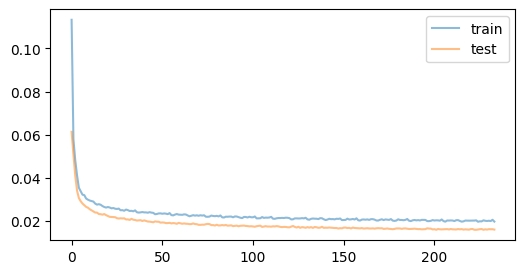

In [31]:
plt.figure(figsize=(6,3))
plt.plot(loss_list_train, alpha=0.5, label='train')
plt.plot(loss_list_test, alpha=0.5, label='test')
# plt.yscale('log')
plt.legend()
plt.savefig('MNIST_entropy_plus_loss.png')
plt.show()

### Reconstruction and distribution graphs

In [32]:
def inf_by_layers_LRAE(model, x_batch):
    # forward pass with intermediate layers
    x_down = model.down(x_batch)
    B, C, H, W = x_down.shape
    x_flat = x_down.view(B,C*H*W)
    encoded_inter_dim =                    model.low_rank.encoder(x_flat)
    encoded_out_dim, factors_probability = model.low_rank.low_rank_pants(encoded_inter_dim)
    
    decoded_inter_dim =                    model.low_rank.intermediate_decoder(encoded_out_dim)
    decoded_1d =                           model.low_rank.decoder(decoded_inter_dim)
    decoded_2d_small = decoded_1d.view(B, C, H, W)
    decoded_2d = model.up(decoded_2d_small)

    return decoded_2d, encoded_out_dim, factors_probability

inf_by_layers = inf_by_layers_LRAE


In [33]:
from ignite.metrics import FID, PSNR
psnr = PSNR(data_range=1)


In [34]:
factors_probability.sum()

tensor(963.0782, device='cuda:0', grad_fn=<SumBackward0>)

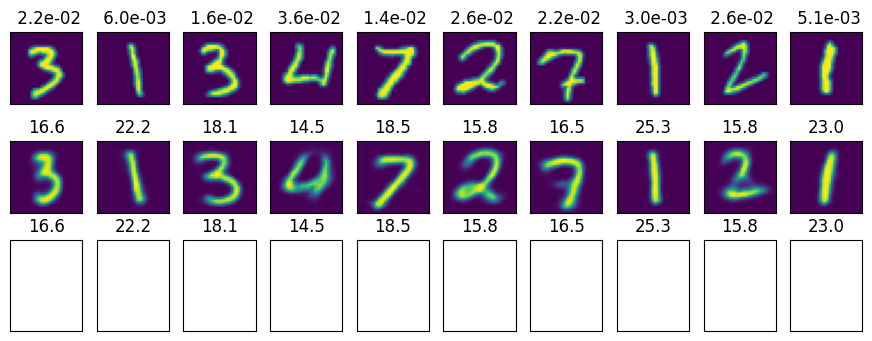

In [35]:
fig, axs = plt.subplots(3,10, figsize=(11,4))

for i in range(0,10):
    INDX=i+30
    #true
    
    #pred
    with torch.no_grad():
        model.eval()
        x_batch = X_full_test[INDX].unsqueeze(0).to(device)
        
        # plotting original images
        axs[0,i].imshow(x_batch[0,0].cpu().detach().numpy()) # mnist
        

        # forward pass with intermediate layers
        decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
        
    axs[1,i].imshow(decoded_2d.cpu().detach().numpy()[0,0]) # mnist
    mse = torch.nn.MSELoss()(decoded_2d[0,0].cpu().detach(), x_batch[0,0].cpu().detach())
    axs[0,i].set_title(f"{mse: .1e}")
    # axs[1,i].set_title(f"{10*torch.log10(1 / (mse + 1e-20)):.1f}")
    axs[1,i].set_title(f"{10*torch.log10(1 / (mse + 1e-20)):.1f}")
    psnr.reset()
    psnr.update([decoded_2d.cpu().detach(), x_batch.cpu().detach()])
    axs[2,i].set_title(f"{psnr.compute():.1f}")
# psnr = PSNR(data_range=1)

    
    # 1d probabilities
    if factors_probability is not None:
        if len(factors_probability.shape) > 2: 
            for j in range(factors_probability.shape[1]):
                axs[2,i].plot(factors_probability[0,j,::].cpu().detach().numpy())
                axs[2,i].set_ylim(-0.1,1.1)
        
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])

# plt.savefig('MNIST_softmax_plus_Reconstruction.png')
plt.show()

In [37]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    decoded_2d1, encoded_out_dim1, factors_probability1 = inf_by_layers(model, X_full_train.to(device))  
    decoded_2d2, encoded_out_dim2, factors_probability2 = inf_by_layers(model, X_full_test.to(device))
    


In [47]:
# MSE
mse_train = torch.nn.MSELoss()(decoded_2d1.cpu().detach(), X_full_train.cpu().detach())
mse_test = torch.nn.MSELoss()(decoded_2d2.cpu().detach(), X_full_test.cpu().detach())
print(f"MSE: {mse_test.item():.4f}({mse_train.item():.4f})")

# PSNR
psnr_train = 10*torch.log10(1 / (mse_train + 1e-20))
psnr_test = 10*torch.log10(1 / (mse_test + 1e-20))

print(f"PSNR: {psnr_test.item():.2f}({psnr_train.item():.2f})")



MSE: 0.0162(0.0161)
PSNR: 17.91(17.93)


#### Dist grapths

In [81]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, X_full_test.to(device))
    decoded_2d1, encoded_out_dim1, factors_probability1 = inf_by_layers(model, X_full_train.to(device))
    


Text(0.5, 0.98, 'Train')

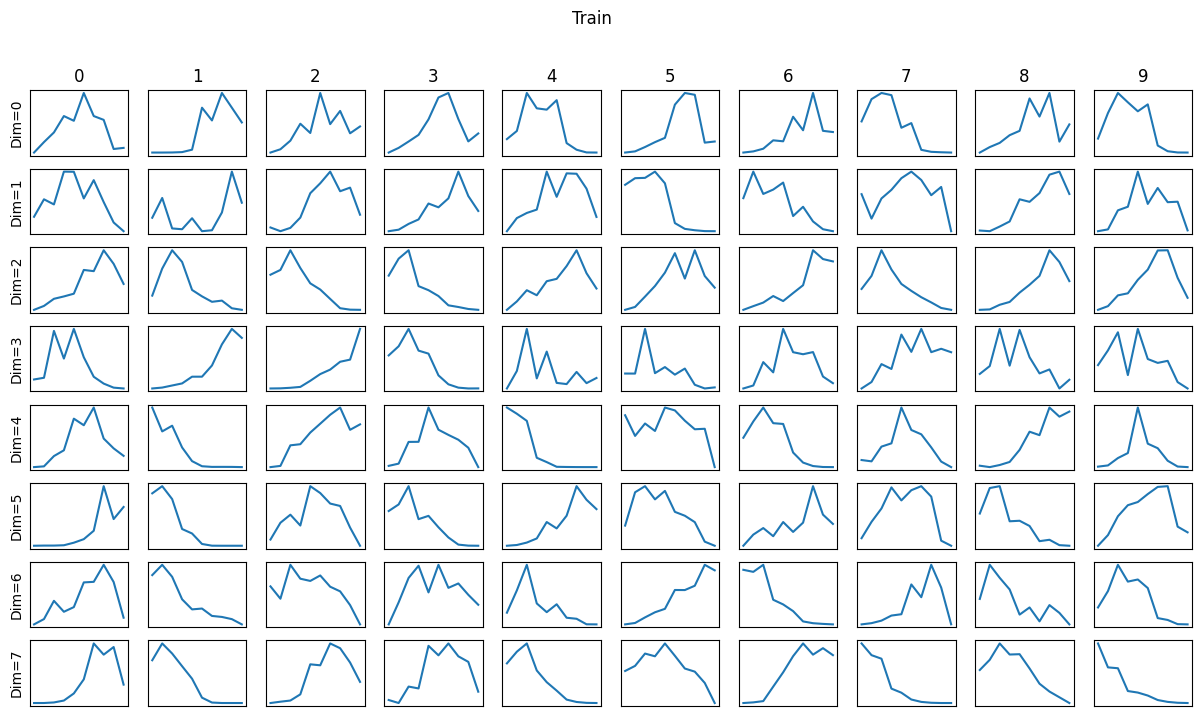

In [107]:
# check z distribution
dim = 0
ny = 10




dy_dim = 1

nx = 8*dy_dim
plt.figure(figsize=[15, nx])

for dim in range(8):
    for i in range(10):
        plt.subplot(nx, ny, (dim*dy_dim)*ny+ i+1)
        plt.plot(factors_probability1.detach().cpu()[targets==i].mean(0)[dim])
        plt.gca().set_yticks([])
        plt.gca().set_xticks([])
        if dim == 0:
            plt.title(f"{i}")
        if i == 0:
            plt.ylabel(f"Dim={dim}")    
        
    # for i in range(10):
    #     plt.subplot(nx, ny, (dim*dy_dim + 1)*ny+ i+1)
    #     plt.hist(encoded_out_dim1[:, dim].detach().cpu()[targets_test==i], bins=20, density=True)
    #     plt.gca().set_yticks([])
    #     plt.gca().set_xticks([])
    #     # plt.title(f"{i}")
    
plt.suptitle(f"Train")




Text(0.5, 0.98, 'Test')

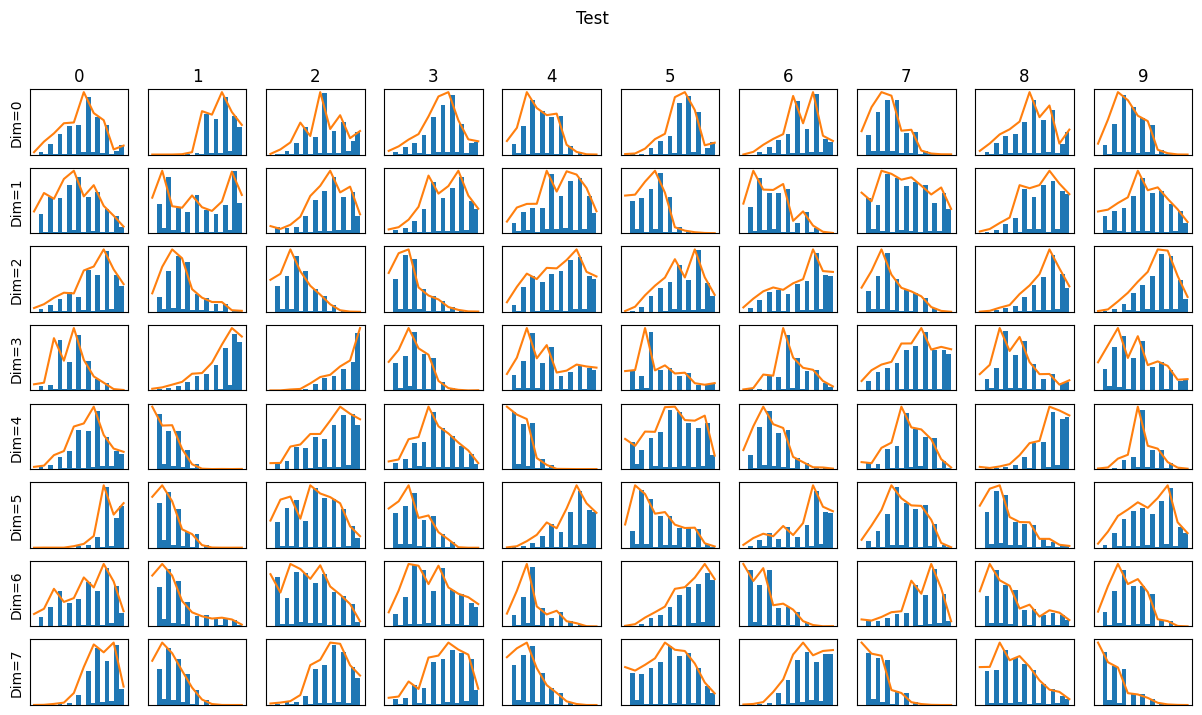

In [119]:
# check z distribution
dim = 0
ny = 10




dy_dim = 1

nx = 8*dy_dim
plt.figure(figsize=[15, nx])

for dim in range(8):
    for i in range(10):
        plt.subplot(nx, ny, (dim*dy_dim)*ny+ i+1)
        plt.hist(encoded_out_dim[:, dim].detach().cpu()[targets_test==i], bins=np.linspace(0, 1, 20), density=True)
        plt.plot(np.linspace(0, 1, 10), factors_probability.detach().cpu()[targets_test==i].mean(0)[dim]*20)
        plt.gca().set_yticks([])
        plt.gca().set_xticks([])
        if dim == 0:
            plt.title(f"{i}")
        if i == 0:
            plt.ylabel(f"Dim={dim}")    
        
    # for i in range(10):
    #     plt.subplot(nx, ny, (dim*dy_dim + 1)*ny+ i+1)
    #     plt.hist(encoded_out_dim1[:, dim].detach().cpu()[targets_test==i], bins=20, density=True)
    #     plt.gca().set_yticks([])
    #     plt.gca().set_xticks([])
    #     # plt.title(f"{i}")
    
plt.suptitle(f"Test")

# for dim in range(8):
#     for i in range(10):
#         plt.subplot(nx, ny, i+1)
#         plt.hist(encoded_out_dim[:, dim].detach().cpu()[targets_test==i], bins=np.linspace(0, 1, 20), density=True, alpha=0.2)
#         plt.gca().set_yticks([])
#         plt.gca().set_xticks([])
#         if dim == 0:
#             plt.title(f"{i}")
#         if i == 0:
#             plt.ylabel(f"Dim={dim}")    
        
#     # for i in range(10):
#     #     plt.subplot(nx, ny, (dim*dy_dim + 1)*ny+ i+1)
#     #     plt.hist(encoded_out_dim1[:, dim].detach().cpu()[targets_test==i], bins=20, density=True)
#     #     plt.gca().set_yticks([])
#     #     plt.gca().set_xticks([])
#     #     # plt.title(f"{i}")
    
# plt.suptitle(f"Test")


In [47]:
encoded_out_dim[:, 0][targets_test==2].detach().cpu().unique().shape

torch.Size([453])

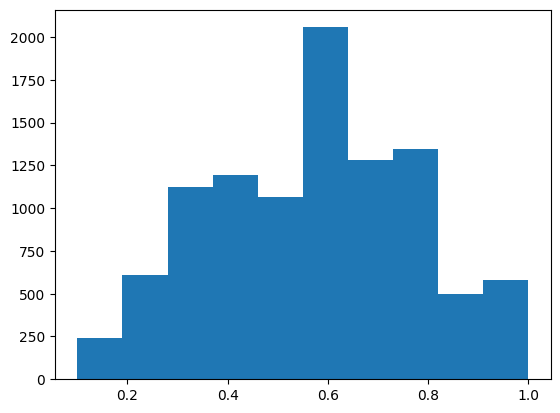

In [49]:
plt.hist(encoded_out_dim[:, 0].detach().cpu(), bins=10)
plt.show()

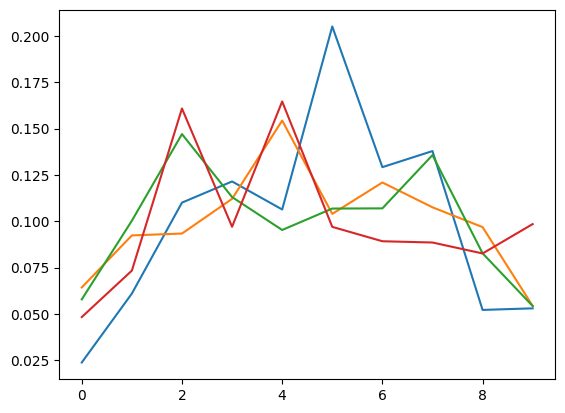

In [27]:
f_mean = np.mean(factors_probability.cpu().detach().numpy(), axis=0)
plt.plot(f_mean[0])
plt.plot(f_mean[1])
plt.plot(f_mean[2])
plt.plot(f_mean[3])
plt.show()

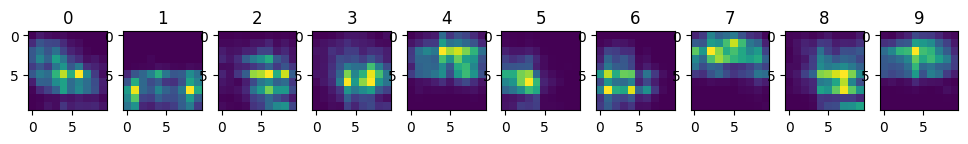

In [28]:
# plot
fig, axs = plt.subplots(1,10, figsize=(12,2))
for i in range(0,10):
    f1, f2 = factors_probability[::,0,::], factors_probability[::,1,::]
    probs = np.zeros((f1.shape[-1],f1.shape[-1]))
    # selecting the encoded distibution vectors
    f1_cls, f2_cls = f1[targets_test == i], f2[targets_test == i]
    for f1_vec, f2_vec in zip(f1_cls, f2_cls):
        probs += np.outer(f1_vec.cpu().detach().numpy(), f2_vec.cpu().detach().numpy())
            
    axs[i].imshow(probs)
#     axs[i].set_xticks(model.range.detach().numpy()/20)
#     axs[i].set_yticks(model.range.detach().numpy()/20)
    
    axs[i].set_title(f'{i}')

plt.savefig('MNIST_softmax_plus_2d_distribution.png')

plt.show()

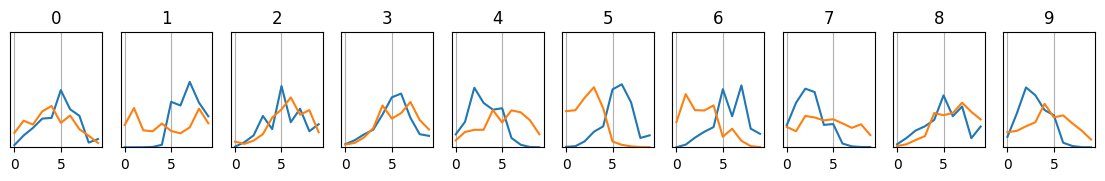

In [29]:
# plot
fig, axs = plt.subplots(1,10, figsize=(14,1.5), sharey=True)
for i in range(0,10):
    axs[i].plot(np.mean(factors_probability.cpu().detach().numpy()[targets_test == i], axis=0)[0])
    axs[i].plot(np.mean(factors_probability.cpu().detach().numpy()[targets_test == i], axis=0)[1])
    
    axs[i].grid(True)
    
    axs[i].set_yticks([])
    axs[i].set_ylim(0,0.5)

    axs[i].set_title(f'{i}')
plt.show()

### Generation

In [52]:
from torcheval.metrics import FrechetInceptionDistance


In [31]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    decoded_2d1, encoded_out_dim1, factors_probability1 = inf_by_layers(model, X_full_train.to(device))  
    decoded_2d2, encoded_out_dim2, factors_probability2 = inf_by_layers(model, X_full_test.to(device))
    
    
    # decoded_2d1 = decoded_2d1*(decoded_2d1 > 0)
    # decoded_2d2 = decoded_2d2*(decoded_2d2 > 0)


In [286]:
# fac_flat = factors_probability1.view(-1,4*20).cpu().detach().numpy()

# plt.figure(figsize=(12,4))
# plt.imshow(fac_flat[::20,].T)
# plt.show()

# u,s,v = np.linalg.svd(fac_flat)

# plt.plot(s/s[0])
# plt.show()

#### PCA

In [69]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

enc_pca = pca.fit_transform(encoded_out_dim1.cpu().detach().numpy())
enc_pca1 = pca.fit_transform(encoded_out_dim2.cpu().detach().numpy())

enc_tsne = tsne.fit_transform(encoded_out_dim1.cpu().detach().numpy())
enc_tsne1 = tsne.fit_transform(encoded_out_dim2.cpu().detach().numpy())

# enc_pca = enc.detach().numpy()
# enc_pca1 = enc1.detach().numpy()

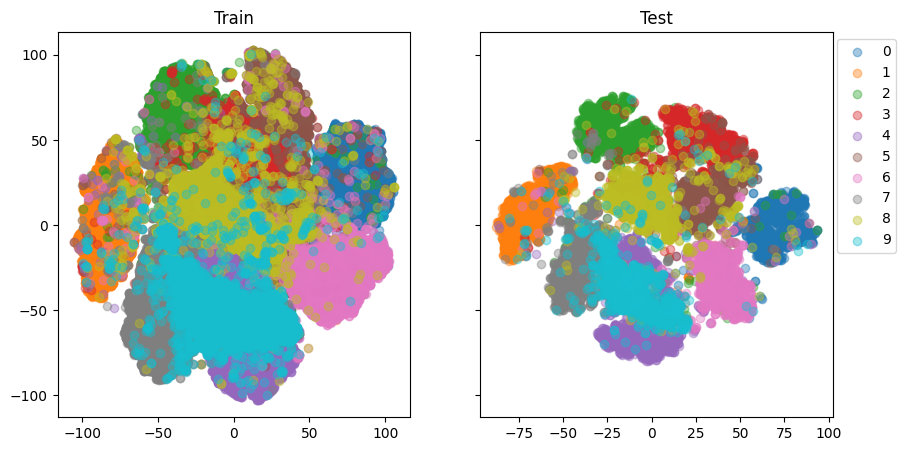

In [70]:
# TSNE
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
for cls in [0,1,2,3,4,5,6,7,8,9]:
    # X_cur = enc.cpu().detach().numpy()[targets == cls]
    X_cur = enc_tsne[targets == cls]
    axs[0].scatter(X_cur[::,0], X_cur[::,1], label=cls, alpha=0.4)
    
    # X_cur1 = enc1.cpu().detach().numpy()[targets_test == cls]
    X_cur1 = enc_tsne1[targets_test == cls]
    axs[1].scatter(X_cur1[::,0], X_cur1[::,1], label=cls, alpha=0.4)

axs[0].set_title('Train')
axs[1].set_title('Test')
plt.legend(bbox_to_anchor=(1.2, 1))
# plt.xlim(-0.1,1.1)
# plt.ylim(-0.1,1.1)
plt.savefig('MNIST_softmax_plus_PCA.png')
plt.show()

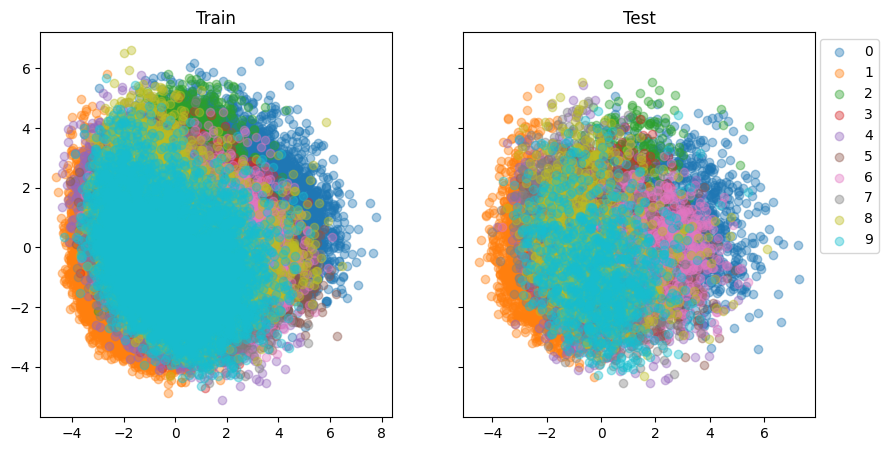

In [67]:
# PCA
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
for cls in [0,1,2,3,4,5,6,7,8,9]:
    # X_cur = enc.cpu().detach().numpy()[targets == cls]
    X_cur = enc_pca[targets == cls]
    axs[0].scatter(X_cur[::,0], X_cur[::,1], label=cls, alpha=0.4)
    
    # X_cur1 = enc1.cpu().detach().numpy()[targets_test == cls]
    X_cur1 = enc_pca1[targets_test == cls]
    axs[1].scatter(X_cur1[::,0], X_cur1[::,1], label=cls, alpha=0.4)

axs[0].set_title('Train')
axs[1].set_title('Test')
plt.legend(bbox_to_anchor=(1.2, 1))
# plt.xlim(-0.1,1.1)
# plt.ylim(-0.1,1.1)
plt.savefig('MNIST_softmax_plus_PCA.png')
plt.show()

In [33]:
EMB_SIZE = 8

In [289]:
EMB_SIZE = 8
PCA_SIZE = 2
pca = PCA(n_components=PCA_SIZE)
pca.fit(encoded_out_dim2.cpu().detach().numpy())
pca.transform(torch.randn(1,EMB_SIZE)*torch.std(encoded_out_dim2, dim=0).cpu()
               + torch.mean(encoded_out_dim2, dim=0).cpu())

array([[ 5.12685038, -2.47813757]])

In [290]:
enc_pca = pca.transform(encoded_out_dim2.cpu().detach().numpy())
mean_enc_pca = np.mean(enc_pca, axis=0)
std_enc_pca = np.std(enc_pca, axis=0)
print(mean_enc_pca)
print(std_enc_pca)

[-3.1302454e-05  4.2345047e-05]
[24.774065 12.882258]


#### FID

In [54]:

device = 'cuda:0'
model = model.to(device)
EMB_SIZE = 8

In [55]:
dataset_list = []
dataset_names = []
ground_truth = X_full_test.detach().cpu()
N_samples = ground_truth.shape[0]
# N_samples = 1000


B = N_samples


# Generating samples Truth

dataset_truth = ground_truth[:B]

dataset_list +=[dataset_truth]
dataset_names += ['Truth']

# Generating samples AE

mean_vec = torch.mean(encoded_out_dim1.to(device), dim=0)
std_vec = torch.std(encoded_out_dim1.to(device), dim=0)
rand = torch.randn([B, EMB_SIZE]).to(device)*std_vec + mean_vec
# rand = (torch.rand(EMB_SIZE).to(device) - 0.5)*30
# x_down = model.down(x_batch.to(device))
C, H, W = 128, 4, 4
decoded_inter_dim =         model.low_rank.intermediate_decoder(rand.to(device))
decoded_1d =                model.low_rank.decoder(decoded_inter_dim)
decoded_2d_small = decoded_1d.view(B, C, H, W)
decoded_2d = model.up(decoded_2d_small)

model_dataset = decoded_2d.detach().cpu()
model_dataset = model_dataset*(model_dataset > 0)
dataset_list +=[model_dataset]
dataset_names += ['VAE']


In [56]:
# FID

torch.cuda.empty_cache()


# fid = FID(device=device)
base_i = 0
compare_i = 1

B_, C_, H_, W_ = dataset_list[0].shape
C_ *= 3 

ch3_compare = transforms.Resize(299)(dataset_list[compare_i].expand(B_, C_, H_, W_))
ch3_base = transforms.Resize(299)(dataset_list[base_i].expand(B_, C_, H_, W_))

ch3_compare = (ch3_compare*(ch3_compare > 0))
ch3_base = (ch3_base*(ch3_base > 0))

In [57]:
batch_size = 512
B = dataset_list[0].shape[0]
idx_ranges = B // batch_size
idx_list = [0] + [batch_size*(ii+1) for ii in range(idx_ranges)]
if B % batch_size != 0:
    idx_list += [B-1]
    
print(batch_size, 'x', len(idx_list)-1, f"== {B}({len(idx_list)*batch_size})")
torch.cuda.empty_cache()

512 x 20 == 10000(10752)


In [58]:
torch.cuda.empty_cache()

In [59]:
# del fid
fid = FrechetInceptionDistance(device=device)

In [71]:
fid.reset()

torch.cuda.empty_cache()
fid_stat_list = []
for idx_start, ids_end in tqdm(zip(idx_list[-2::-1], idx_list[-1:0:-1]), total=len(idx_list)-1):
# for idx_start, ids_end in tqdm(zip(idx_list[:-1:], idx_list[1:]), total=len(idx_list)-1):
    with torch.no_grad():
        fid.update(ch3_base[idx_start:ids_end].to(device), is_real=True)
        fid.update(ch3_compare[idx_start:ids_end].to(device), is_real=False)
        fid_stat = fid.compute().detach().cpu()
        fid_stat_list += [fid_stat]
        # print(fid_stat)

print(fid_stat)

100%|██████████| 20/20 [04:25<00:00, 13.28s/it]

tensor(36.2362)


In [80]:
fid.reset()

torch.cuda.empty_cache()
fid_stat_list = []
for idx_start, ids_end, idx_start_i, ids_end_i in tqdm(zip(idx_list[:-1], idx_list[1:], idx_list[-2::-1], idx_list[-1:0:-1]), total=len(idx_list)-1):
    with torch.no_grad():
        fid.update(ch3_base[idx_start:ids_end].to(device), is_real=True)
        fid.update(ch3_compare[idx_start_i:ids_end_i].to(device), is_real=False)
        fid_stat = fid.compute().detach().cpu()
        fid_stat_list += [fid_stat]
        print(fid_stat)
        fid.reset()
        # print(fid_stat)

print(fid_stat)

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:05<01:38,  5.17s/it]

tensor(51.1187)


 10%|█         | 2/20 [00:14<02:15,  7.52s/it]

tensor(46.1099)


 15%|█▌        | 3/20 [00:23<02:16,  8.05s/it]

tensor(46.0949)


 20%|██        | 4/20 [00:30<02:06,  7.93s/it]

tensor(46.1936)


 25%|██▌       | 5/20 [00:41<02:12,  8.86s/it]

tensor(46.8251)


 30%|███       | 6/20 [00:50<02:07,  9.12s/it]

tensor(45.7253)


 35%|███▌      | 7/20 [00:59<01:56,  8.93s/it]

tensor(46.8826)


 40%|████      | 8/20 [01:09<01:50,  9.18s/it]

tensor(45.9887)


 45%|████▌     | 9/20 [01:19<01:43,  9.44s/it]

tensor(47.1062)


 50%|█████     | 10/20 [01:26<01:28,  8.88s/it]

tensor(49.9272)


 55%|█████▌    | 11/20 [01:35<01:19,  8.88s/it]

tensor(52.5034)


 60%|██████    | 12/20 [01:59<01:47, 13.46s/it]

tensor(54.9676)


 65%|██████▌   | 13/20 [02:07<01:22, 11.80s/it]

tensor(50.9047)


 70%|███████   | 14/20 [02:15<01:03, 10.63s/it]

tensor(58.0032)


 75%|███████▌  | 15/20 [02:25<00:52, 10.42s/it]

tensor(53.4015)


 80%|████████  | 16/20 [02:34<00:40, 10.05s/it]

tensor(69.0146)


 85%|████████▌ | 17/20 [02:44<00:30, 10.07s/it]

tensor(52.9881)


 90%|█████████ | 18/20 [02:52<00:18,  9.23s/it]

tensor(61.9218)


 95%|█████████▌| 19/20 [02:59<00:08,  8.69s/it]

tensor(47.3659)


100%|██████████| 20/20 [03:04<00:00,  9.21s/it]

tensor(57.7956)
tensor(57.7956)


In [61]:
a = set([1, 2, 3, 4, 5])

AttributeError: 'set' object has no attribute 'next'

tensor(51.5419)

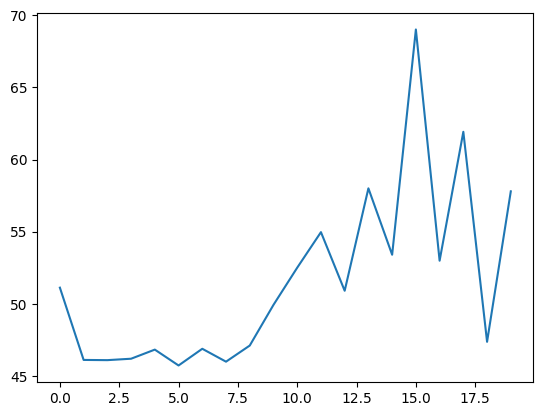

In [81]:
plt.plot(fid_stat_list)
torch.as_tensor(fid_stat_list).mean()

In [344]:
print(ch3_base.min(), ch3_base.max())
print(ch3_compare.min(), ch3_compare.max())

tensor(0.) tensor(1.)
tensor(-0.) tensor(0.9997)


In [326]:
fid_stat

tensor(177.1130, device='cuda:1')

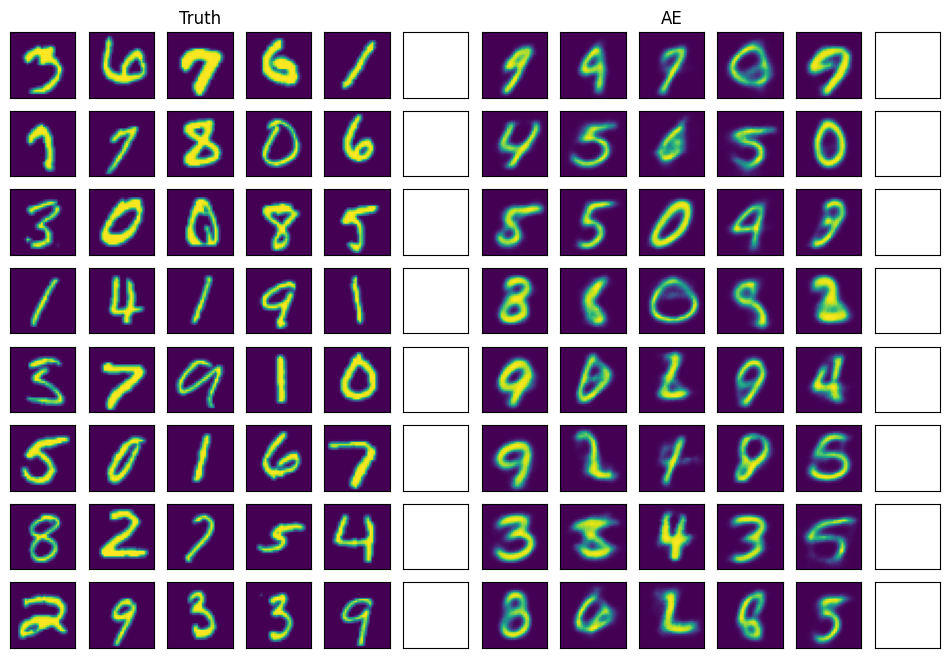

In [65]:
# Displaying several samples
# easy display
W_n = 5
H_n = 8
n_datasets = len(dataset_list)

j_title = W_n//2 
def_name = "-"

plt.figure(figsize=[1*(W_n+1)*n_datasets, 1*H_n])

for idx_dataset, dataset_ in enumerate(dataset_list):
    dataset = dataset_[torch.randperm(dataset_.shape[0])]
    for i in range(H_n):
        for j in range(W_n+1):
            plt.subplot(H_n, (W_n+1)*n_datasets, i*(W_n+1)*n_datasets + j+1 + idx_dataset*(W_n+1))
            # print(i, j, idx_dataset, i*(W_n+1)*n_datasets + j+1 + idx_dataset*(W_n+1))
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            
            if j == W_n:
                continue

            plt.imshow(dataset[i*H_n + j].permute(1, 2, 0))
            
            # plt.box(False)
            
            if j == j_title and i == 0:
                plt.title(dataset_names[idx_dataset] if len(dataset_names) > idx_dataset else def_name)
                
                

        
            
# # FID
# fid = FID(num_features=32*32)
# base_i = 0
# compare_i = 1
# fid.reset()
# fid.update([dataset_list[compare_i].reshape(N_samples, 32*32), dataset_list[base_i].reshape(N_samples, 32*32)])
# print(f"Fid = {fid.compute():.2f}")
    
    



torch.Size([1000, 8])

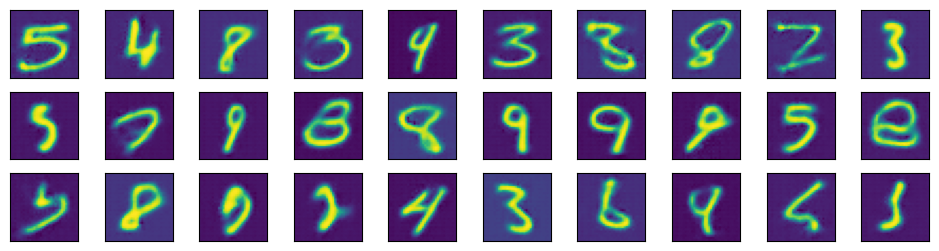

In [40]:
# plot
EMB_SIZE = 8

fig, axs = plt.subplots(3,10, figsize=(12,3))
for i in range(0,10):
    with torch.no_grad():
        model.eval()

        for j in range(3):
            mean_vec = torch.mean(encoded_out_dim1, dim=0)
            std_vec = torch.std(encoded_out_dim1, dim=0)
            rand = torch.randn([1000, EMB_SIZE]).to(device)*std_vec + mean_vec
            # rand = (torch.rand(EMB_SIZE).to(device) - 0.5)*30
            x_down = model.down(x_batch)
            B, C, H, W = (1000,128,4,4)
            decoded_inter_dim =         model.low_rank.intermediate_decoder(rand.to(device))
            decoded_1d =                model.low_rank.decoder(decoded_inter_dim)
            decoded_2d_small = decoded_1d.view(B, C, H, W)
            decoded_2d = model.up(decoded_2d_small)

            axs[j,i].imshow(decoded_2d.cpu().detach().numpy()[0,0])



    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])
#     axs[i].set_title(f'{i}')

plt.savefig('MNIST_softmax_plus_Generation.png')
plt.show()

In [170]:
from ignite.metrics import PSNR

In [135]:
X_full_train.shape

torch.Size([60000, 1, 32, 32])

In [137]:
default_evaluator = X_full_train[:3]
default_evaluator.shape

torch.Size([3, 1, 32, 32])

In [148]:
torch.nn.MSELoss()(X_full_train, X_full_train)

tensor(0.)

In [180]:
X_full_train[:3, :, :, :]

torch.Size([3, 1, 32, 32])

In [174]:
X_full_test.shape

torch.Size([10000, 1, 32, 32])

In [177]:
torch.nn.MSELoss()(X_full_train[0:10000], X_full_test)

tensor(0.1129)

In [175]:
10*torch.log10(1 / (torch.nn.MSELoss()(X_full_train[0:10000], X_full_test) + 1e-10))

tensor(9.4721)

In [165]:
psnr = PSNR(data_range=1)
psnr.reset()
psnr.update([X_full_train[0:10000], X_full_train[0:10000]])
psnr.compute()


100.0

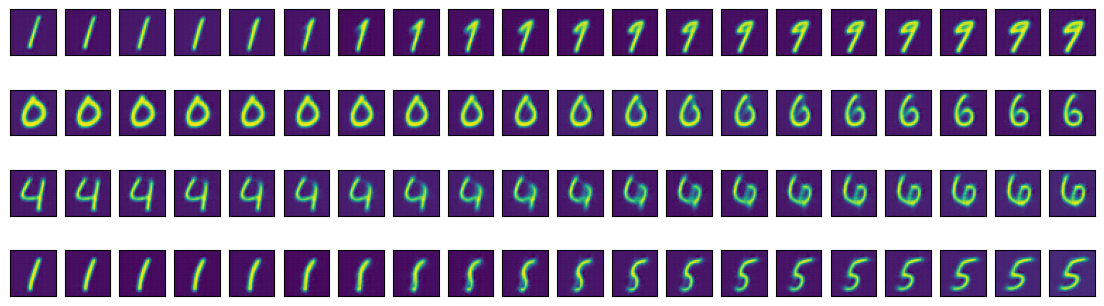

In [129]:
# plot
EMB_SIZE = 8

fig, axs = plt.subplots(4,20, figsize=(14,4))
for i in range(0,20):
    with torch.no_grad():
        model.eval()
            
        for j in range(4):
            # encode two numbers
            # NUMBER 1
            IDX_1 = j+2
            x_down1 = model.down(X_full_test[IDX_1].unsqueeze(0).to(device))
            B, C, H, W = x_down1.shape
            x_flat1 = x_down1.view(B,C*H*W)
            encoded_inter_dim1 =                    model.low_rank.encoder(x_flat1)
            encoded_out_dim1, factors_probability1 = model.low_rank.low_rank_pants(encoded_inter_dim1)

            # NUMBER 2
            IDX_2 = j+20
            x_down2 = model.down(X_full_test[IDX_2].unsqueeze(0).to(device))
            B, C, H, W = x_down2.shape
            x_flat2 = x_down2.view(B,C*H*W)
            encoded_inter_dim2 =                    model.low_rank.encoder(x_flat2)
            encoded_out_dim2, factors_probability2 = model.low_rank.low_rank_pants(encoded_inter_dim2)

            # decode and plot
            new_encoded = (1-i/axs.shape[-1])*encoded_out_dim1 + (i/axs.shape[-1])*encoded_out_dim2
            decoded_inter_dim =  model.low_rank.intermediate_decoder(new_encoded)
            decoded_1d = model.low_rank.decoder(decoded_inter_dim)
            decoded_2d_small = decoded_1d.view(B, C, H, W)
            decoded_2d = model.up(decoded_2d_small)

            axs[j,i].imshow(decoded_2d.cpu().detach().numpy()[0,0])
            axs[j,i].set_xticks([])
            axs[j,i].set_yticks([])
plt.show()

In [131]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    decoded_2d1, encoded_out_dim1, factors_probability1 = inf_by_layers(model, X_full_train.to(device))  
    decoded_2d2, encoded_out_dim2, factors_probability2 = inf_by_layers(model, X_full_test.to(device))

In [132]:
# getting probability tensor from single rank-1 factors
def get_prob_tensor(factors):
    f_init = torch.tensor(1.).to(device)
    for factor in factors:
        f_init = torch.tensordot(f_init, factor, dims=0)
    return f_init

N_SUM = 1032

prob_tensor_train = get_prob_tensor(factors_probability1[0])
for i in tqdm(range(1,len(factors_probability1))[0:N_SUM]):
    prob_tensor_train += get_prob_tensor(factors_probability1[i])

prob_tensor_train = prob_tensor_train/N_SUM

TypeError: 'NoneType' object is not subscriptable

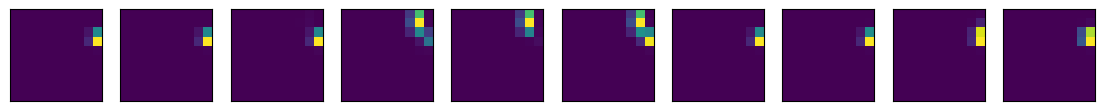

In [225]:
fig, axs = plt.subplots(1,10, figsize=(14,2))
for i in range(10):
    axs[i].imshow(prob_tensor_train[i][9][0][0][0][0].cpu().detach().numpy())
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()


In [226]:
def get_sample_vec(prob_tensor, N_iter=100):
    feature_size = len(prob_tensor.shape)
    n_bins = prob_tensor.shape[0]
    
    vector = torch.zeros(feature_size).to(device)
    probs_sum = 0
    for i in range(N_iter):
        xyzt = torch.randint(low=0,high=n_bins, size=(feature_size,)).to(device)
        prob_coef = prob_tensor_train[tuple(xyzt)]
        vector += (xyzt+1)*prob_coef # +1 because we made range from 1 to n_bins + 1
        probs_sum += prob_coef
    # normalizing
    vector = vector/probs_sum#*torch.numel(prob_tensor)/N_iter
    return vector/n_bins, probs_sum/N_iter
    

In [227]:
get_sample_vec(prob_tensor_train, N_iter=10)

(tensor([0.7891, 0.6447, 0.7113, 0.9556, 0.7225, 0.7225, 0.4113, 0.9000],
        device='cuda:0'),
 tensor(1.4993e-16, device='cuda:0'))

100%|██████████| 3/3 [00:09<00:00,  3.01s/it]


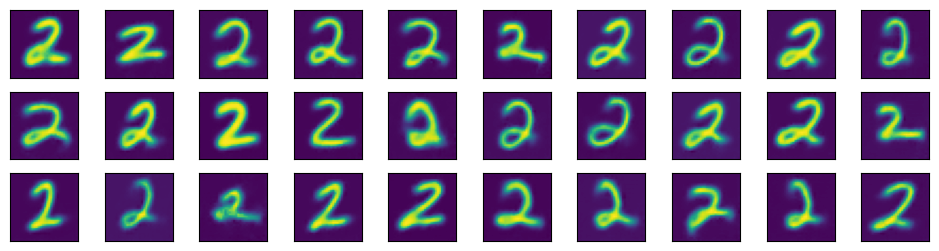

In [229]:
# plot
EMB_SIZE = 8

fig, axs = plt.subplots(3,10, figsize=(12,3))
for i in range(0,10):
    with torch.no_grad():
        model.eval()

        for j in tqdm(range(3)):
            prob = 0
            while prob < torch.mean(prob_tensor_train) + 2*torch.std(prob_tensor_train):
                rand, prob = get_sample_vec(prob_tensor_train, N_iter=10)
            x_down = model.down(x_batch)
            B, C, H, W = (1,128,4,4)
            decoded_inter_dim =         model.low_rank.intermediate_decoder(rand.to(device))
            decoded_1d =                model.low_rank.decoder(decoded_inter_dim)
            decoded_2d_small = decoded_1d.view(B, C, H, W)
            decoded_2d = model.up(decoded_2d_small)

            axs[j,i].imshow(decoded_2d.cpu().detach().numpy()[0,0])



    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])
#     axs[i].set_title(f'{i}')

plt.savefig('MNIST_softmax_plus_Generation.png')
plt.show()

### work with sampling 

In [441]:
#### work with sampling 

digit = 2
digit_X = X_full_test[targets_test == digit]
digit_X = X_full_test

with torch.no_grad():
    model.eval()
    
    out, enc, factors_prob = inf_by_layers(model, digit_X.to(device))
    # out, enc, factors_prob = model(digit_X.unsqueeze(1).to(device))  
    # model(digit_X)
    
out = out.detach().cpu().squeeze().numpy() 
enc, factors_prob = enc.detach().cpu().numpy(), factors_prob.detach().cpu().numpy()

factors_prob.shape

(10000, 8, 10)

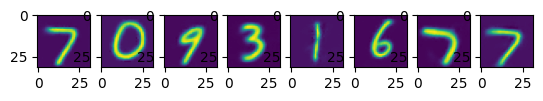

In [442]:
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(out[i*10])

In [450]:
def sampling_from_proba(factors_probability, model):

    # randomized selection + added eps
    dropped_factors = model.low_rank.low_rank_pants.dropout(factors_probability) + model.low_rank.low_rank_pants.eps

    # normalization
    normalized_drop_factors = dropped_factors/(torch.sum(dropped_factors, dim=-1, keepdim=True))

    # choosing the sampling
    if model.low_rank.low_rank_pants.sampling == 'vector':
        encoded =  vector_sampling(normalized_drop_factors, model.low_rank.grid)
    elif model.low_rank.low_rank_pants.sampling == 'softmax':
        encoded = softmax_sampling(normalized_drop_factors, model.low_rank.low_rank_pants.grid, model.low_rank.low_rank_pants.temperature)
    elif model.low_rank.low_rank_pants.sampling == 'gumbell':
        encoded = gumbell_sampling(normalized_drop_factors, model.low_rank.low_rank_pants.grid, model.low_rank.low_rank_pants.temperature)

    encoded_out_dim = encoded
    return encoded_out_dim


def decoding_of_encoded_out(encoded_out_dim, model, C=C, H=H, W=W):
    
    decoded_inter_dim = model.low_rank.intermediate_decoder(encoded_out_dim)
    # # skipconnection
    # if np.random.rand(1)[0]>0.9:
    #     decoded_1d = model.low_rank.decoder(decoded_inter_dim)
    # else:
    #     decoded_1d = model.low_rank.decoder(encoded_inter_dim)

    decoded_1d = model.low_rank.decoder(decoded_inter_dim)

    # 2d upsampling
    B = encoded_out_dim.shape[0]
    decoded_2d_small = decoded_1d.view(B, C, H, W)
    decoded_2d = model.up(decoded_2d_small)
    return decoded_2d

    
    
    

In [445]:
factors_probability.shape

torch.Size([10000, 8, 10])

In [449]:
H = 4
W = 4

In [451]:
H = 4
W = 4
with torch.no_grad():
    model.eval()
    ###
    factors_probability = torch.from_numpy(factors_prob).to(device)

    encoded_out_dim = sampling_from_proba(factors_probability, model)
    decoded_2d = decoding_of_encoded_out(encoded_out_dim, model )

    out_rand = decoded_2d.detach().cpu().numpy()
    
    ##

    encoded_out_dim = sampling_from_proba(factors_probability, model)
    decoded_2d = decoding_of_encoded_out(encoded_out_dim, model )

    out_rand1 = decoded_2d.detach().cpu().numpy()

# out_rand1 = out_rand

In [218]:
out_rand1.shape

(1032, 1, 32, 32)

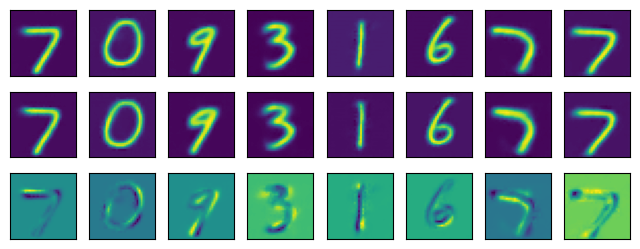

In [452]:
plt.figure(figsize=(8, 3))
for i in range(8):
    plt.subplot(3, 8, i+1)
    plt.imshow(out_rand[i*10, 0])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
# plt.show()

for i in range(8):
    plt.subplot(3, 8, 8 + i+1)
    plt.imshow(out_rand1[i*10, 0])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
# plt.show()

for i in range(8):
    plt.subplot(3, 8, 8*2 + i+1)
    plt.imshow(out_rand1[i*10, 0] - out_rand[i*10, 0] )
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])


##### seporatly

j = 0; Error:  0.0010470056365599575
j = 1; Error:  0.001311280906492276
j = 2; Error:  0.0007366122097073414
j = 3; Error:  0.0009596660429310918
j = 4; Error:  0.0008040597128933805
j = 5; Error:  0.0014850612518628814
j = 6; Error:  0.0010366359571744668
j = 7; Error:  0.0011625380016972722


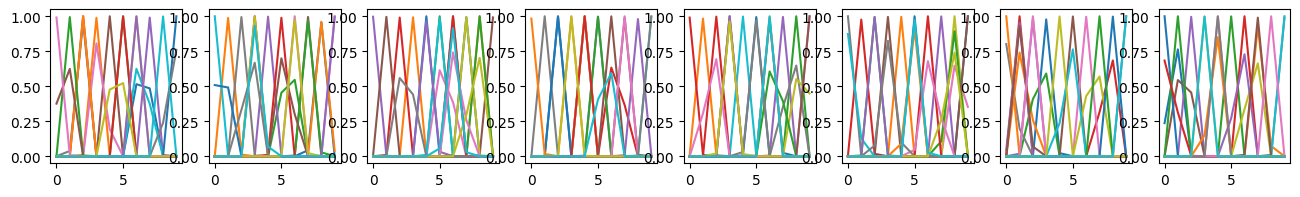

In [453]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

factor_rank = 20

comp_list = []
L = 8
plt.figure(figsize=[2*L, 2])
for j in range(L):
    nmf = NMF(n_components=factor_rank, max_iter=500, init='random')
    
    factor_j = factors_prob[:, j, :]
    # print(np.sum(factor_j))
    nmf.fit(factor_j)
    print(f"j = {j}; Error: ", nmf.reconstruction_err_/np.linalg.norm(factor_j))
    # u, sigma, v = np.linalg.svd(factor_j, full_matrices=False)
    components = nmf.components_
    # break
    # components = components.sum(0, keepdims=True)
    plt.subplot(1, L, j+1)
    plt.plot((components/components.sum(1, keepdims=True)).T)
    
    components = components.reshape(components.shape[0:1] + (1,1) + components.shape[1:2])

    comp_list += [components]
    
normalized_factors_np = np.concatenate(comp_list, 2 )
    

In [282]:
factor_j = factors_prob.reshape(factors_prob.shape[0], -1)
factor_j.shape

(1032, 80)

In [285]:
(factor_j.reshape(factors_prob.shape[0], L, -1) - factors_prob).sum()

0.0

In [292]:
components.shape

(100, 80)

##### stacking

Error:  0.5109439979986998


/tmp/ipykernel_204861/2090603347.py:38: RuntimeWarning: invalid value encountered in divide
  plt.plot((components__/components__.sum(1, keepdims=True)).T)


(40, 1, 8, 10)


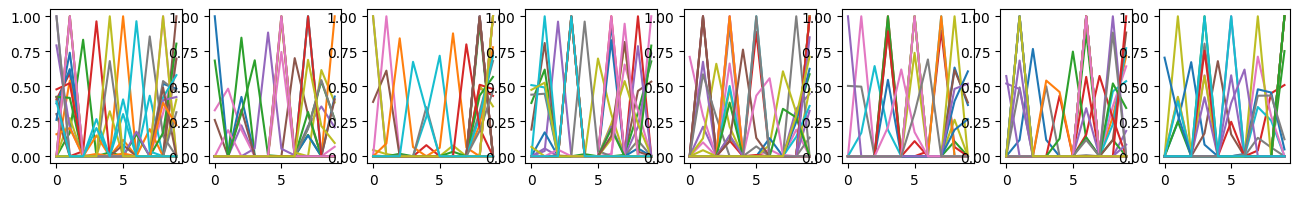

In [461]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

factor_rank = 40

comp_list = []
L = 8

err_list = []

nmf = NMF(n_components=factor_rank, max_iter=1000, init='random')
# nmf = TruncatedSVD(n_components=factor_rank)

factor_j = factors_prob.reshape(factors_prob.shape[0], -1)
nmf.fit(factor_j)
# err_list += [ nmf.reconstruction_err_/np.linalg.norm(factor_j)]
print(f"Error: ", nmf.reconstruction_err_/np.linalg.norm(factor_j))
# print(f"Error: ", nmf.explained_variance_)
# plt.plot(nmf.explained_variance_)
plt.show()
# u, sigma, v = np.linalg.svd(factor_j, full_matrices=False)
components = nmf.components_

H = nmf.transform(factor_j)
W = nmf.components_

H_n = H / np.linalg.norm(H, axis=0, keepdims=True)
sigm = np.linalg.norm(H, axis=0, keepdims=True)
W_ = sigm.T * W

components = W_
components_arr = components.reshape(components.shape[0], L, -1)
plt.figure(figsize=[2*L, 2])
for j in range(L):
    plt.subplot(1, L, j+1)
    components__ = components_arr[:,j,:]
    plt.plot((components__/components__.sum(1, keepdims=True)).T)

# components = components.reshape(components.shape[0:1] + (1,1) + ())

# comp_list += [components]


normalized_factors_np = components_arr.reshape(components_arr.shape[0], 1, *components_arr.shape[1:])
print(normalized_factors_np.shape)
# normalized_factors_np = torch.mean(normalized_factors_np, )
    

In [316]:
H = nmf.transform(factor_j)

In [317]:
factor_j.shape

(1032, 80)

In [318]:
W = nmf.components_

In [356]:
H_n = H / np.linalg.norm(H, axis=0, keepdims=True)

sigm = np.linalg.norm(H, axis=0, keepdims=True)


W_ = sigm.T * W

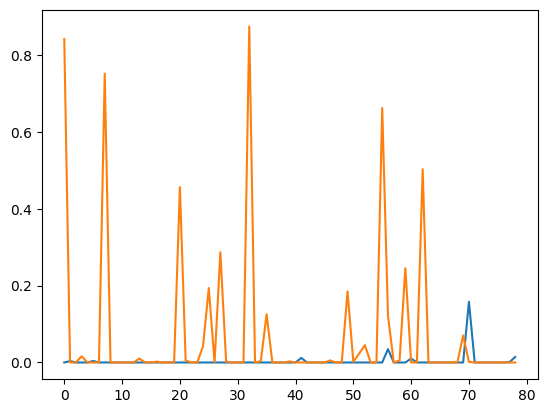

In [369]:
plt.plot(W[:, 0])
plt.plot(H[0, :])

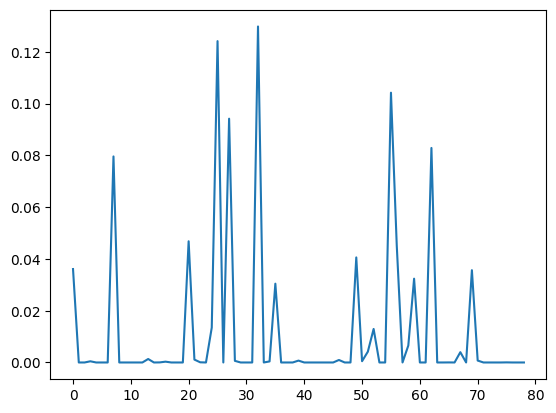

In [364]:
plt.plot(H_n[0, :])

In [372]:
np.linalg.norm(H_n @ W_ - H @ W)/np.linalg.norm(H @ W)

4.7927333e-08

0.9424656

0.9424656

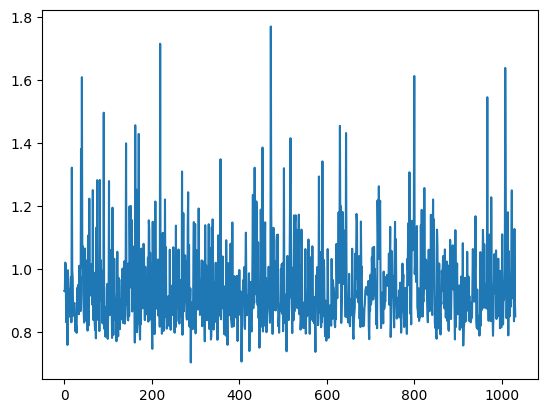

In [373]:
plt.plot(H_n.sum(1))
H_n.sum(1).mean()

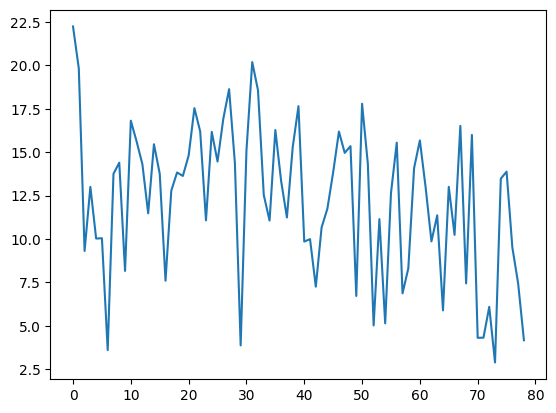

In [348]:
plt.plot(H_n.sum(0))

In [323]:
np.linalg.norm(H @ W - factor_j) / np.linalg.norm(factor_j)

0.03315872

In [ ]:
np.sum(nmf., )

##### Generating

In [454]:
# normalized_factors_np = (np.abs(normalized_factors_np) + normalized_factors_np)/2


In [465]:
normalized_factors_np_ = normalized_factors_np/(normalized_factors_np.sum(-1, keepdims=True) + 1e-9)
# normalized_factors_np_ = np.mean(normalized_factors_np_, 0, keepdims=True)
normalized_factors_ = torch.from_numpy(normalized_factors_np_).to(device)
normalized_factors_.shape

torch.Size([40, 1, 8, 10])

In [456]:
# normalized_factors_ = torch.abs(normalized_factors_)

In [458]:
# normalized_factors_ < 0

100%|██████████| 40/40 [00:19<00:00,  2.04it/s]


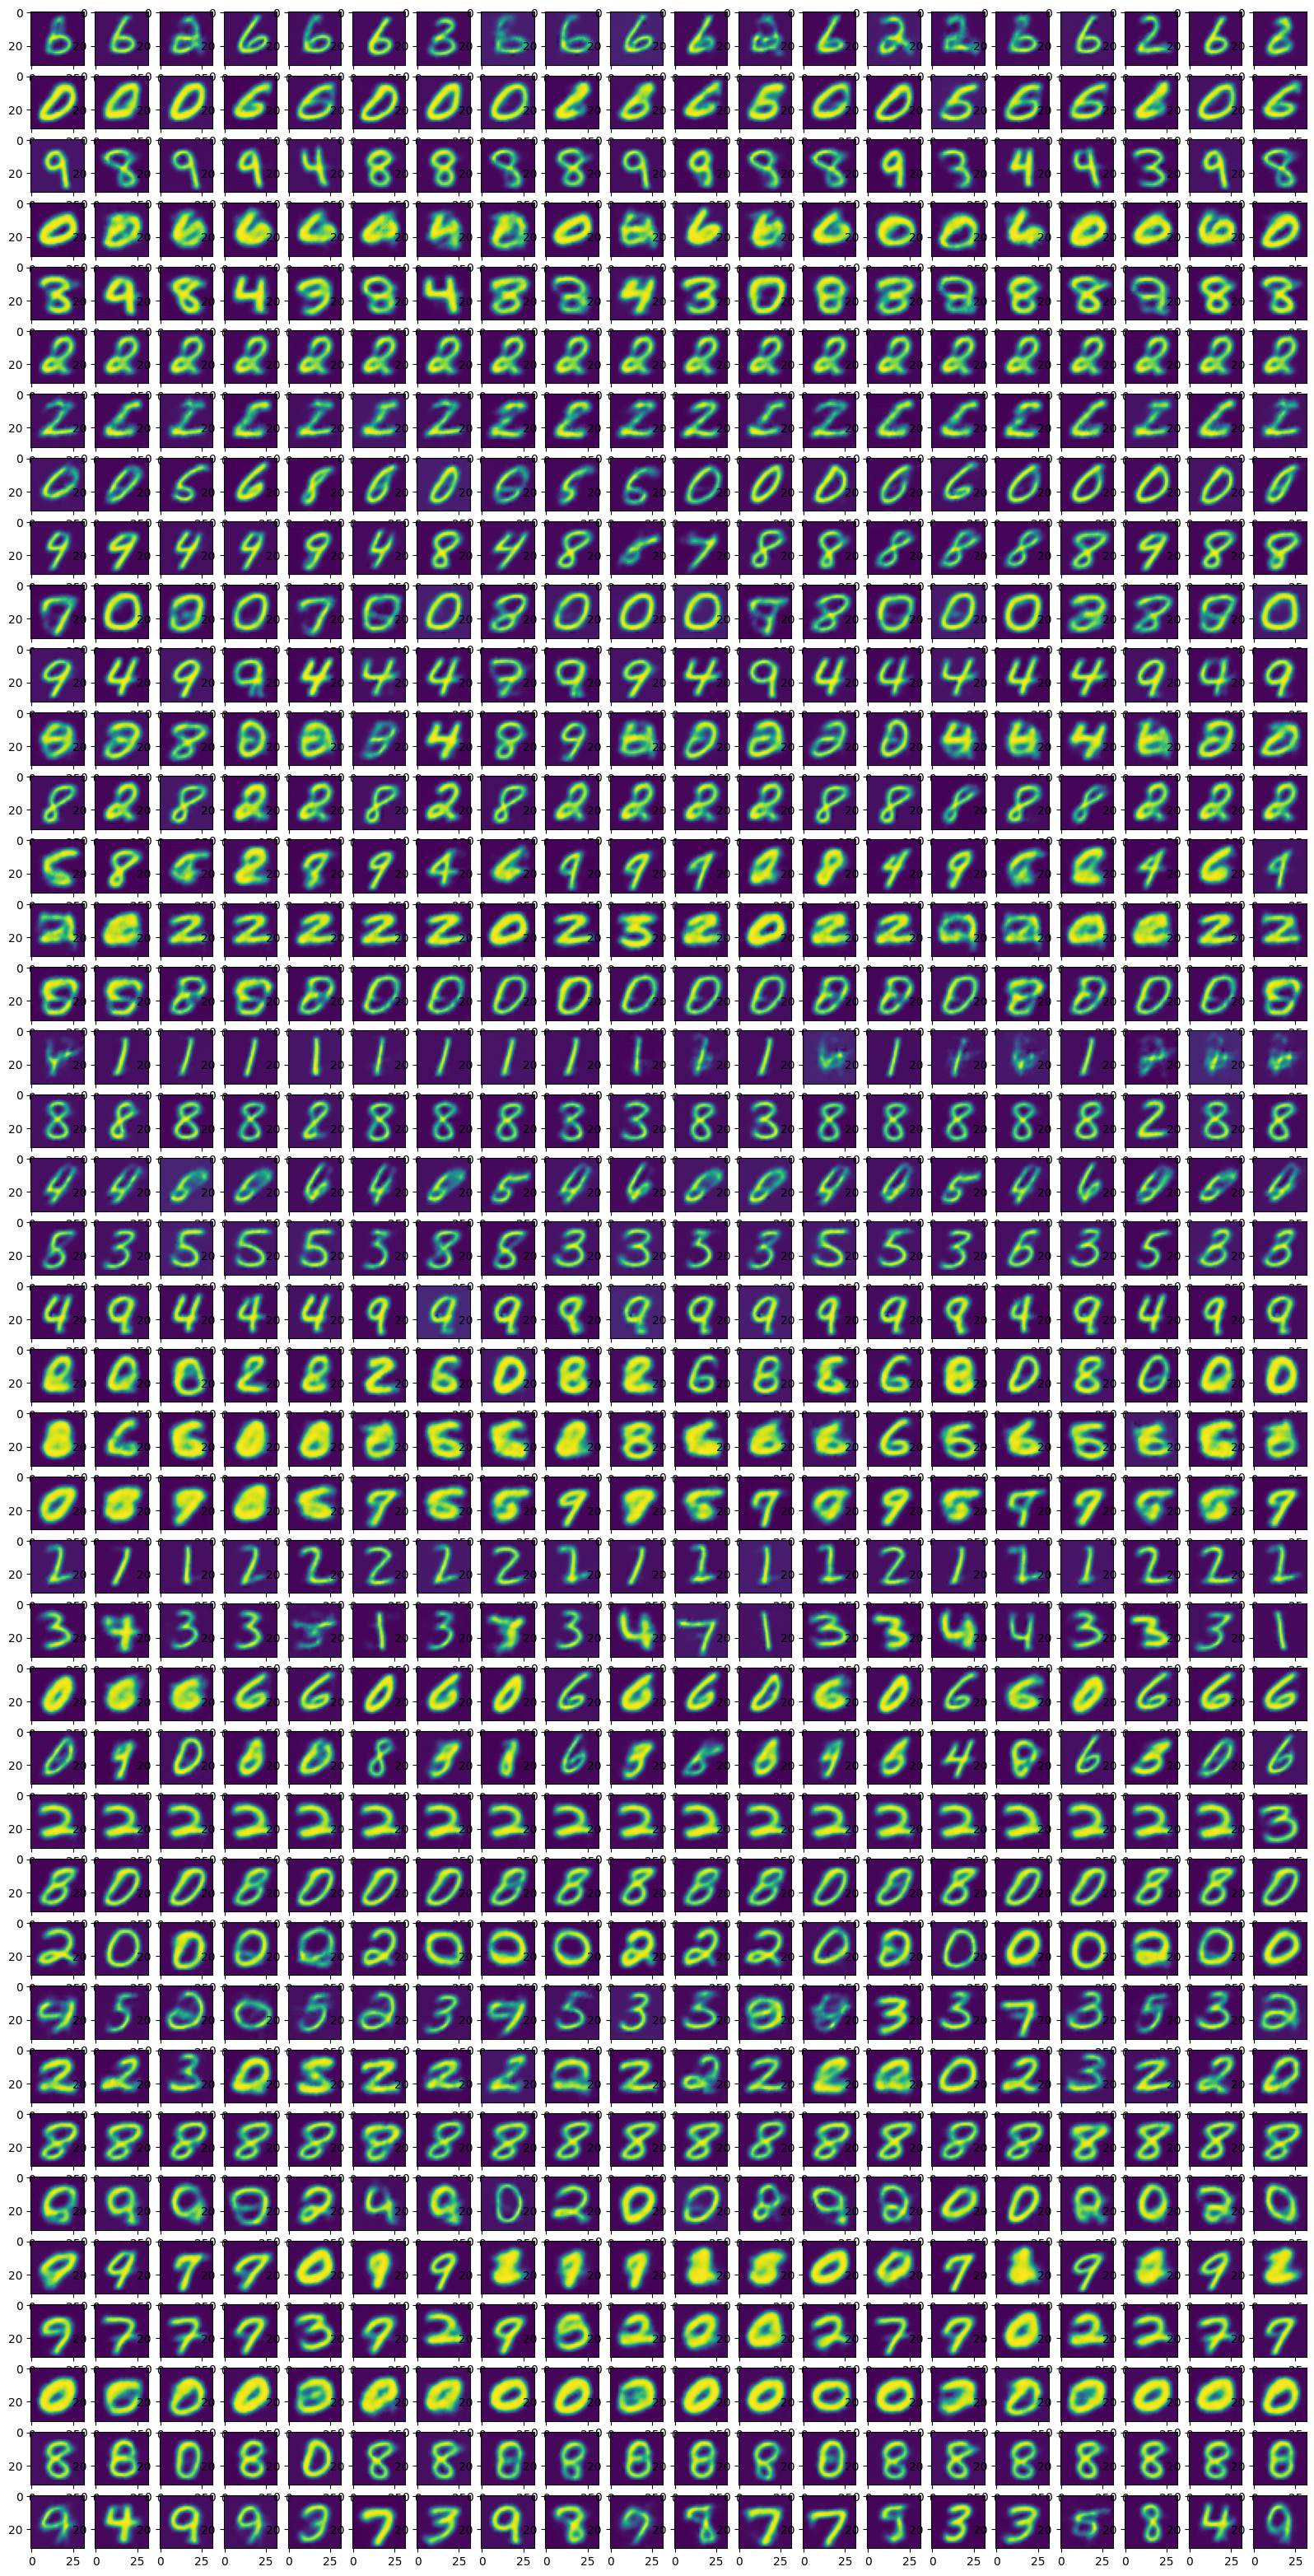

In [466]:

Nx, Ny = normalized_factors_.shape[0], 20
plt.figure(figsize=[Ny, Nx*1])
optimizer.zero_grad()
with torch.no_grad():
    for i in tqdm(range(Nx )):
        for j in range(Ny):
            plt.subplot(Nx, Ny, i*Ny+j+1)
            normalized_factors = normalized_factors_[i]
            model.eval()
            encoded_out_dim = sampling_from_proba(normalized_factors, model)
            decoded_2d = decoding_of_encoded_out(encoded_out_dim, model )

            out_rand_ = decoded_2d.detach().cpu().numpy()
                    
            plt.imshow(out_rand_[0, 0])
        
    

In [195]:

encoded_out_dim

tensor([[0.9000, 0.1015,    nan, 0.6000, 0.4000, 0.3000,    nan, 0.4000]],
       device='cuda:0')

In [167]:
decoded_1d.shape

torch.Size([1032, 2048])

### Classification test

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### from factors_probability 

In [ ]:
with torch.no_grad():
    model.eval()
    # Train
    x_batch = X_full_train.to(device)
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
    prob_latent_train = factors_probability.reshape(factors_probability.shape[0], -1).detach().cpu()
    
    #Test
    x_batch = X_full_test.to(device)
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
    prob_latent_test = factors_probability.reshape(factors_probability.shape[0], -1).detach().cpu()
    
    
# for j in range(factors_probability.shape[1]):
#     plt.plot(factors_probability[0, j, :].detach().cpu())

In [ ]:
X_class_train, X_class_test = prob_latent_train, prob_latent_test

In [ ]:
# Low rank
n_components = 20
pca_ = PCA(n_components=prob_latent_train.shape[-1])
pca_.fit(prob_latent_train)
plt.plot(pca_.explained_variance_)
plt.vlines([n_components], ymin = plt.gca().get_ylim()[0], ymax = plt.gca().get_ylim()[1], colors=['r'], linestyles=['--'])

pca_f = PCA(n_components=prob_latent_train.shape[-1]).fit(prob_latent_train)
X_class_train = pca_f.transform(prob_latent_train)
X_class_test= pca_f.transform(prob_latent_test)


#### from encoded_out_dim

In [ ]:
with torch.no_grad():
    model.eval()
    # Train
    x_batch = X_full_train.to(device)
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
    # prob_latent_train = factors_probability.reshape(factors_probability.shape[0], -1).detach().cpu()
    encoded_out_dim_train = encoded_out_dim.detach().cpu()
    
    #Test
    x_batch = X_full_test.to(device)
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
    prob_latent_test = factors_probability.reshape(factors_probability.shape[0], -1).detach().cpu()
    encoded_out_dim_test = encoded_out_dim.detach().cpu()
    
   


In [ ]:
X_class_train, X_class_test = encoded_out_dim_train, encoded_out_dim_test

In [ ]:
(encoded_out_dim_train != X_class_train).sum()

#### Classification  

In [ ]:
X_train, y_train = X_class_train, targets
X_test, y_test= X_class_test, targets_test

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)


In [ ]:
plt.figure(figsize=[15, 6])
nx, ny = 2, 5
for i in range(10):
    plt.subplot(nx, ny, i+1)
    plt.bar(np.arange(clf.coef_.shape[1])+1, clf.coef_[i, :])
    if i % ny != 0:
        plt.gca().set_yticks([])
        
    # plt.gca().set_yticks([-10, 0, 10])
    plt.gca().set_ylim([-40, 40])
    plt.gca().set_xticks([])
    # plt.grid()
    plt.title(str(i))

In [ ]:
# for i in range(10):
#     plt.scatter(clf.coef_[i, 0], clf.coef_[i, 1],)

In [ ]:
print(classification_report(y_train, y_pred_train))
print()
print(classification_report(y_test, y_pred_test))

In [ ]:
# plt.figure(figsize=[16, 4])

# # plt.subplot(1, 3, 1)
# plt.figure(figsize=[8, 7])
# cm = confusion_matrix(y_train, y_pred_train, labels=clf.classes_, normalize='all')
# disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm, 3), display_labels=clf.classes_)
# disp.plot(ax = plt.gca())
# plt.title('Train')
# plt.show()



# plt.subplot(1, 3, 2)
plt.figure(figsize=[8, 7])
cm = confusion_matrix(y_test, y_pred_test, labels=clf.classes_, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm, 2), display_labels=clf.classes_)
disp.plot(ax = plt.gca())
plt.title('Test')